# Feature Selection and Model Comparison for Alzheimer's Disease Detection

## 1. Setup

In [1]:
import os, sys
from sys import platform
_base_path = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(_base_path)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
from src.helpers.utils import make_dataset

In [2]:
data_path, meta_path = make_dataset(dataset='oasis_aug', base_path=_base_path, verbose=False)

## 2. Feature Selection

In [3]:
data = pd.read_csv(os.path.join(meta_path, 'data_num.csv'))
features_all = ['sex', 'age', 'ethnicity', 'education', 'marriage', 'weight', 'height', 'smoke', 'brain_disease', 'heart_disease', 'cdr_memory', 'cdr_orientation', 'cdr_judgment', 'cdr_community', 'cdr_hobbies', 'cdr_personalcare', 'boston_naming_test', 'depression', 'sleeping_disorder', 'motor_disturbance']

- Splitting dataset into training and testing set.

- Scaling data into `[0, 1]` interval.

- Applying `RandomForestClassifier`.

- Plotting the features ordered by importance.

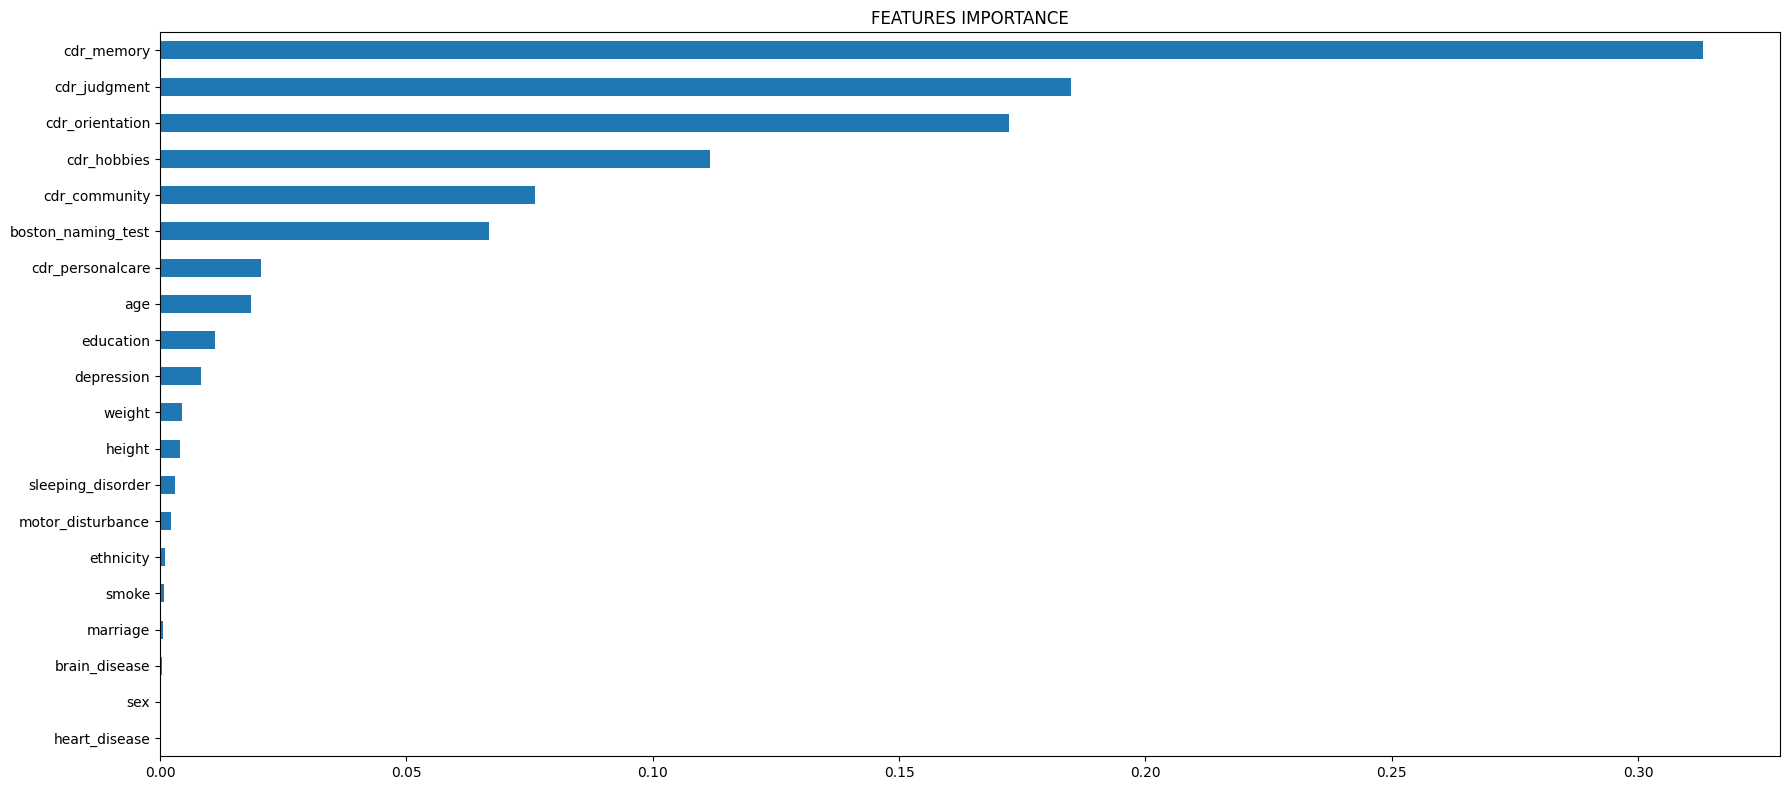

In [4]:
warnings.filterwarnings('ignore')
X = data[features_all]
y = data[['final_dx']]
X_train, X_test, y_train, y_test = train_test_split(
	X.values.astype('float64'),
	y.values.astype('float64'),
	train_size = .8,
	test_size = .2,
	random_state = 3,
	shuffle = True,
	stratify = y
)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh', ax=ax, title='FEATURES IMPORTANCE')
fig.tight_layout()
plt.show()

- Definition of two new features set:

	- the **selected features** set which contains the most discriminant ones according to `RandomForestClassifier`;

	- the **demographic features** set which excludes the features strongly correlated with the label (i.e. `boston_naming_test` and all `cdr_` related ones).

In [5]:
data1 = data[(data['weight'] != .0) & (data['height'] != .0)]
data['bmi'] = round(data1['weight'] / (data1['height'] * data1['height']), 0)
data['bmi'] = data['bmi'].fillna(.0)
features_selected = ['sex', 'age', 'bmi', 'education', 'cdr_memory', 'cdr_orientation', 'cdr_judgment', 'cdr_community', 'cdr_hobbies', 'cdr_personalcare', 'boston_naming_test', 'depression', 'sleeping_disorder', 'motor_disturbance']
features_demo = ['age', 'ethnicity', 'education', 'weight', 'height', 'brain_disease', 'heart_disease', 'depression', 'sleeping_disorder', 'motor_disturbance']

## 3. Model Comparison

Execution of two ensambles (`RandomForestClassifier` and `AdaBoostClassifier`) on the three features sets mentioned above comparison of the results.

In [10]:
print(''.join(['> ' for i in range(50)]))
print(f'\n{"CLASSIFIER":<15}{"FEATURES":<15}{"ACCURACY":>6}{"PRECISION":>15}{"RECALL":>15}{"F1_SCORE":>15}{"ROC_AUC":>15}\n')
print(''.join(['> ' for i in range(50)]))
warnings.filterwarnings('ignore')
models = {
	'RANDOM_FOREST': RandomForestClassifier(n_estimators=50, max_depth=5, random_state=3),
	'ADABOOST': AdaBoostClassifier(n_estimators=20, random_state=3)
}
select = ['ALL', 'SELECTION', 'DEMO']
for m in models.keys():
	for k, f in enumerate([features_all, features_selected, features_demo]):
		X = data[f]
		y = data[['final_dx']]
		X_train, X_test, y_train, y_test = train_test_split(
			X.values.astype('float64'),
			y.values.astype('float64'),
			train_size = .8,
			test_size = .2,
			random_state = 3,
			shuffle = True,
			stratify = y
		)
		scaler = MinMaxScaler()
		X_train = scaler.fit_transform(X_train)
		X_test = scaler.fit_transform(X_test)
		y_train = y_train.reshape(len(y_train),)
		y_test = y_test.reshape(len(y_test),)
		model = models[m]
		model.fit(X_train, y_train)
		pred = model.predict(X_test)
		acc = accuracy_score(pred, y_test)
		prec = precision_score(pred, y_test)
		rec = recall_score(pred, y_test)
		f1 = f1_score(pred, y_test)
		auc = roc_auc_score(pred, y_test)
		if k != 1:
			print(f'{m:<15}{select[k]:<15}{acc:>6.4f}{prec:>15.4f}{rec:>15.4f}{f1:>15.4f}{auc:>15.4f}')
		else:
			print(f'\033[1m{m:<15}{"SELECTION":<15}{acc:>6.4f}{prec:>15.4f}{rec:>15.4f}{f1:>15.4f}{auc:>15.4f}\033[0m')
	print('\n')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

CLASSIFIER     FEATURES       ACCURACY      PRECISION         RECALL       F1_SCORE        ROC_AUC

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
RANDOM_FOREST  ALL            0.9784         0.9828         0.9744         0.9785         0.9784
RANDOM_FOREST  SELECTION      0.9827         0.9828         0.9828         0.9828         0.9827
RANDOM_FOREST  DEMO           0.7835         0.7500         0.8056         0.7768         0.7849


ADABOOST       ALL            0.9740         0.9655         0.9825         0.9739         0.9741
ADABOOST       SELECTION      0.9827         0.9828         0.9828         0.9828         0.9827
ADABOOST       DEMO           0.7186         0.5603         0.8228         0.6667         0.7436


